In [159]:
import numpy as np
import matplotlib.pyplot as plt
import build.pybind_modules.dsp_module as cu
import build.pybind_modules.matrix_module as myMatrix
import os
import librosa
from scipy.io import wavfile
from scipy import signal
from IPython.display import Audio

In [160]:
# Parameters used on tablet 
fs = 48000
nfft = 256
noverlap = -1
nfilt = 40
num_ceps = 13
nn_data_rows = 12
nn_data_cols = 48

In [161]:
def soundDataToFloat(SD):
    "Converts integer representation back into librosa-friendly floats, given a numpy array SD"
    return np.array([ np.float32(s/32768.0) for s in SD])

In [162]:
def createButter(N, Wn, fs):
    num, den = signal.butter(N, Wn, btype='low', analog=False, output='ba', fs=fs)
    return np.array([num[i]/den[i] for i in range(len(num))])

def createFIR(num_taps, cut_off, fs):
    return signal.firwin(num_taps, cut_off, fs=fs)

def displayFIR(filt):
    coef_str = "{" 
    for val in filt: 
        coef_str += str(val) + ", " 
    coef_str = coef_str[:-2] 
    coef_str += "};" 
    print("FIR a Coefficients")
    print(coef_str) 

def applyFIR(samples, filt):
    circBuf = np.zeros(len(filt))
    circBufIdx = 0
    filteredSamples = np.zeros(len(samples))
    num_taps = len(filt)

    for i in range(len(samples)):
        circBuf[circBufIdx] = samples[i]
        curr_val = 0

        for n in range(num_taps):
            curr_val += filt[n] * circBuf[ (((circBufIdx - n) % num_taps) + num_taps) % num_taps]

        filteredSamples[i] = curr_val 
        circBufIdx = (circBufIdx + 1) % num_taps

    return filteredSamples

def trimSamples(samples, desired_num_frames, noverlap, nfft):
    if (noverlap < 0):
        noverlap = int(nfft / 2)

    step = nfft - noverlap

    return samples[:desired_num_frames*step]

In [163]:
raw_data = np.genfromtxt('Tue Apr 18 23:15:54 CDT 2023_rawsamples.csv', delimiter=',', dtype=np.int16)
my_data = np.genfromtxt('Tue Apr 18 23:16:23 CDT 2023_processed.csv', delimiter=',', dtype=np.float32)
my_data = np.reshape(my_data, (12,48))
print("raw_data dtype: {}".format(raw_data.dtype))
print("my_data dtype: {}".format(my_data.dtype))


raw_data dtype: int16
my_data dtype: float32


In [164]:
Audio(raw_data, rate=fs)

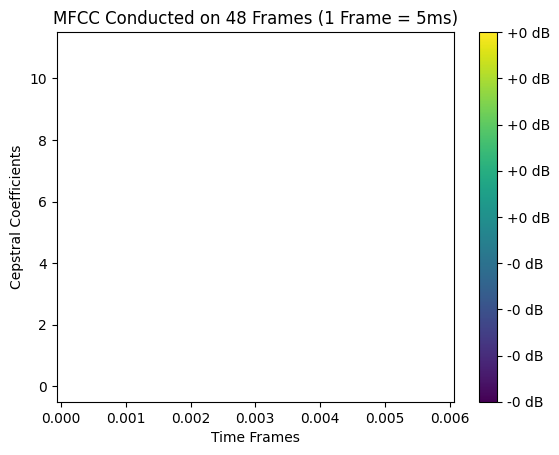

In [165]:
t_time = nn_data_cols / 8000
t = np.linspace(0, t_time, nn_data_cols)
n = np.arange(nn_data_rows)
plt.figure()
plt.pcolormesh(t,n,my_data)
plt.xlabel("Time Frames")
plt.ylabel("Cepstral Coefficients")
plt.title("MFCC Conducted on 48 Frames (1 Frame = 5ms)")
plt.colorbar(format="%+2.f dB")

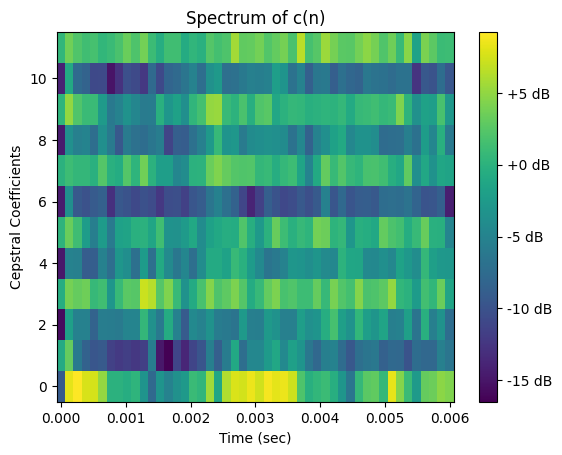

In [166]:
sig = soundDataToFloat(raw_data)

filt = createFIR(51, 3500, fs=fs)
filtered_sig = applyFIR(sig, filt)

filtered_sig = np.array([filtered_sig[i] for i in range(0, len(filtered_sig), 6)])
fs = 8000

curr_processed = np.array(myMatrix.MFCC_Matrix(list(filtered_sig), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)[1:,:]

t_time = nn_data_cols / fs
data = np.zeros((nn_data_rows, nn_data_cols))
for row in range(nn_data_rows):
    for col in range(nn_data_cols):
        data[row,col] = curr_processed[row,col]

t = np.linspace(0, t_time, nn_data_cols)
n = np.arange(nn_data_rows)
plt.title("Spectrum of c(n)")
plt.ylabel("Cepstral Coefficients")
plt.xlabel("Time (sec)")
plt.pcolormesh(t, n, data)
plt.colorbar(format="%+2.f dB")

In [167]:
print(curr_processed)

[[-9.35561666e+00  8.22188342e+00  9.23138173e+00 ... -1.04315775e+02
  -2.17810515e+02 -2.52502050e+02]
 [-8.77231711e-01  3.11220489e+00 -6.10564431e+00 ...  7.64930450e+00
   7.63970035e+00  4.90834194e+00]
 [-1.57246359e+01 -1.99107232e+00 -5.25822891e+00 ... -6.92565128e+01
  -1.82033480e+02 -2.13470247e+02]
 ...
 [ 1.96941585e-01  5.01054226e+00  2.09486416e+00 ... -5.18318494e+00
  -5.21237266e+00 -5.56311741e+00]
 [-1.41157763e+01 -9.27132866e-01 -7.70760467e+00 ... -5.58836008e+01
  -1.58951216e+02 -1.79415621e+02]
 [ 4.78934399e-01  3.62322520e+00  2.11686380e+00 ... -5.00745958e+00
  -4.88410713e+00 -6.94810236e+00]]


In [168]:
# checking the data type from our dataset
# curr_dir = os.getcwd() + '/' + 'AudioMNIST/data'
# curr_dir = os.getcwd() + '/raw_voice_files/0_jorge/0'
# sig, fs = librosa.load(os.getcwd() + '/raw_voice_files/0_jorge/0'+'/'+'2023_03_24_16_23_23.wav', sr=8000)
# fs, sig = wavfile.read(curr_dir+'/'+'01'+'/'+'0_01_0.wav')
fs, sig = wavfile.read(os.getcwd()+'/raw_voice_files/0_jorge/0/2023_03_24_16_20_10.wav')
# sig = raw_data
print("new fs: {}".format(fs))
print("original dtype: {}".format(sig.dtype))

sig = soundDataToFloat(sig)
print(sig)

filt = createFIR(51, 3500, fs=fs)
filtered_sig = applyFIR(sig, filt)

filtered_sig = np.array([filtered_sig[i] for i in range(0, len(filtered_sig), 6)])
fs = 8000

num_negs = 0
print(sig)
for i in range(len(sig)):
    if sig[i] < 0:
        num_negs += 1

print("Num negs: {}".format(num_negs))
print("Data type: {}".format(sig.dtype))

new fs: 48000
original dtype: int16
[ 0.          0.          0.         ... -0.0010376  -0.00097656
 -0.00091553]
[ 0.          0.          0.         ... -0.0010376  -0.00097656
 -0.00091553]
Num negs: 55216
Data type: float32


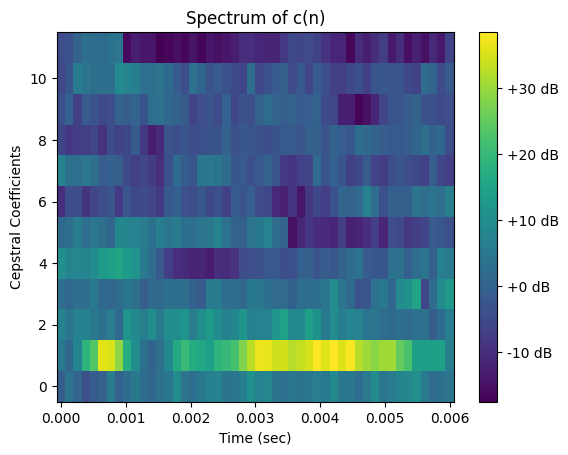

In [169]:
curr_processed = np.array(myMatrix.MFCC_Matrix(list(filtered_sig), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)[1:,:].ravel()
t_time = nn_data_cols / fs
data = np.resize(curr_processed,(nn_data_rows, nn_data_cols))
t = np.linspace(0, t_time, nn_data_cols)
n = np.arange(nn_data_rows)
plt.title("Spectrum of c(n)")
plt.ylabel("Cepstral Coefficients")
plt.xlabel("Time (sec)")
plt.pcolormesh(t, n, data)
plt.colorbar(format="%+2.f dB")

In [170]:
# printing the FIR filter coefficients to use on the Android tablet
displayFIR(filt)

FIR a Coefficients
{-0.0009154526549517794, -0.0011114542578674472, -0.0011748111621119072, -0.0009912202839374121, -0.00040566875669237703, 0.0006928645047039383, 0.0022655744122396246, 0.004040327999447895, 0.005495567242988037, 0.005941591839728333, 0.004700288764397637, 0.0013495643820975742, -0.004031166285818187, -0.010692574509175845, -0.017194526140070547, -0.021572582846390315, -0.021684691762467997, -0.015679166273036733, -0.002483205556162394, 0.017807916482357168, 0.043749754550979104, 0.07264355863368925, 0.10091303015030824, 0.12470091418085558, 0.14056680266815558, 0.14613752935346994, 0.14056680266815555, 0.12470091418085556, 0.10091303015030822, 0.07264355863368924, 0.0437497545509791, 0.01780791648235716, -0.0024832055561623935, -0.015679166273036726, -0.021684691762467987, -0.021572582846390312, -0.017194526140070544, -0.01069257450917584, -0.004031166285818185, 0.0013495643820975731, 0.004700288764397637, 0.005941591839728333, 0.005495567242988034, 0.004040327999447

In [182]:
sample_rate = 8000
NFFT = 256
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (2*(k - bin[m - 1])) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (2*(bin[m + 1] - k)) / (bin[m + 1] - bin[m])

print(len(np.where(fbank == 0)[0]))

4952


In [184]:
sig = soundDataToFloat(raw_data)

filt = createFIR(51, 3500, fs=fs)
filtered_sig = applyFIR(sig, filt)

filtered_sig = np.array([filtered_sig[i] for i in range(0, len(filtered_sig), 6)])
fs = 8000

f, t, result = signal.stft(filtered_sig, fs=fs)
result = abs(result)**2
ret = fbank @ result
print(len(np.where(fbank == 0)[0]))
print(len(np.where(result == 0)[0]))
print(len(np.where(ret == 0)[0]))

4952
774
240
